Thanks to https://www.kaggle.com/chankhavu/a-beginner-s-tpu-kernel-single-model-0-97 for this baseline notebook

In [1]:
!pip install -q efficientnet

import os
import re
import time
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import math
from kaggle_datasets import KaggleDatasets
import kernel_tensorflow_utils as ktu
import efficientnet.tfkeras as efficientnet

ktu.HardwareInfo.print_tf_version()
sns.set()

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
TensorFlow Version:  2.2.0


# Configure TPU

Here, we resolve TPU delegate. If found, we connect to the cluster and initialize the TPU for use. Then, we create a distribution strategy (since we will have not one, but 8 TPU cores in the instance, each with 8GB of in-unit memory). You can find more resources in following links:

* [Tensorflow quick guide on using TPU](https://www.tensorflow.org/guide/tpu#improving_performance_by_multiple_steps_within_tffunction)
* [Kaggle TPU Documentation](https://www.kaggle.com/docs/tpu)
* [Kaggle discussions on training optimization](https://www.kaggle.com/c/flower-classification-with-tpus/discussion/135443)

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Importing Data

First, we define the paths to our data. The dataset contains different directories for different image sizes, ranging from 192, 224, 331, to 512. We will only use the size 224, as it is consistent with input sizes of models pre-trained on ImageNet. We will use two sets of data:

* [`tpu-getting-started`](https://www.kaggle.com/c/tpu-getting-started/data) - the dataset of this competition
* [`tf-flower-photo-tfrec`](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec) - the dataset from previous similar competition (+55k images) with the same structure

In [3]:
# Let's use 224x224 by default
image_size = (224, 224)

# Data dirs
data_gcs = KaggleDatasets().get_gcs_path('tpu-getting-started')
ext_gcs = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

# Subdirs by image size
data_dir_by_size = {
    (512, 512): '/tfrecords-jpeg-512x512',
    (331, 331): '/tfrecords-jpeg-331x331',
    (224, 224): '/tfrecords-jpeg-224x224',
    (192, 192): '/tfrecords-jpeg-192x192'
}
subdir = data_dir_by_size[image_size]

# Paths to data files
train_file_names = tf.io.gfile.glob(data_gcs + subdir + '/train' + '/*.tfrec')
val_file_names = tf.io.gfile.glob(data_gcs + subdir + '/val' + '/*.tfrec')
test_file_names = tf.io.gfile.glob(data_gcs + subdir + '/test' + '/*.tfrec')

# Extending the dataset with additional data
imagenet_files = tf.io.gfile.glob(ext_gcs + '/imagenet' + subdir + '/*.tfrec')
inaturelist_files = tf.io.gfile.glob(ext_gcs + '/inaturalist' + subdir + '/*.tfrec')
openimage_files = tf.io.gfile.glob(ext_gcs + '/openimage' + subdir + '/*.tfrec')
oxford_files = tf.io.gfile.glob(ext_gcs + '/oxford_102' + subdir + '/*.tfrec')
tensorflow_files = tf.io.gfile.glob(ext_gcs + '/tf_flowers' + subdir + '/*.tfrec')

train_file_names = train_file_names + imagenet_files + inaturelist_files + \
    openimage_files + oxford_files + tensorflow_files

In [4]:
# Classification Categories in our Dataset
flower_categories = [
    'pink primrose',     'hard-leaved pocket orchid', 'canterbury bells',
    'sweet pea',         'wild geranium',             'tiger lily',
    'moon orchid',       'bird of paradise',          'monkshood',
    'globe thistle',     'snapdragon',                'colt\'s foot',
    'king protea',       'spear thistle',             'yellow iris',
    'globe-flower',      'purple coneflower',         'peruvian lily',
    'balloon flower',    'giant white arum lily',     'fire lily',
    'pincushion flower', 'fritillary',                'red ginger',
    'grape hyacinth',    'corn poppy',                'prince of wales feathers',
    'stemless gentian',  'artichoke',                 'sweet william',
    'carnation',         'garden phlox',              'love in the mist',
    'cosmos',            'alpine sea holly',          'ruby-lipped cattleya',
    'cape flower',       'great masterwort',          'siam tulip',
    'lenten rose',       'barberton daisy',           'daffodil',
    'sword lily',        'poinsettia',                'bolero deep blue',
    'wallflower',        'marigold',                  'buttercup',
    'daisy',             'common dandelion',          'petunia',
    'wild pansy',        'primula',                   'sunflower',
    'lilac hibiscus',    'bishop of llandaff',        'gaura',
    'geranium',          'orange dahlia',             'pink-yellow dahlia',
    'cautleya spicata',  'japanese anemone',          'black-eyed susan',
    'silverbush',        'californian poppy',         'osteospermum',
    'spring crocus',     'iris',                      'windflower',
    'tree poppy',        'gazania',                   'azalea',
    'water lily',        'rose',                      'thorn apple',
    'morning glory',     'passion flower',            'lotus',
    'toad lily',         'anthurium',                 'frangipani',
    'clematis',          'hibiscus',                  'columbine',
    'desert-rose',       'tree mallow',               'magnolia',
    'cyclamen ',         'watercress',                'canna lily',
    'hippeastrum ',      'bee balm',                  'pink quill',
    'foxglove',          'bougainvillea',             'camellia',
    'mallow',            'mexican petunia',           'bromelia',
    'blanket flower',    'trumpet creeper',           'blackberry lily',
    'common tulip',      'wild rose'
]

print('Number of flower categories:', len(flower_categories))

Number of flower categories: 104


Now, we just need to form a dataset out of the `*.tfrec` files. Below, we define some helper functions to combine them into a single memory map and parse the structure of our dataset into a more standard `(image, label)` format for classification. Please refer to [Tensorflow Data API](https://www.tensorflow.org/guide/data_performance) and [TFRecordDataset Documentation](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset) for more information.

In [5]:
def decode_image(image_data):
    """Decodes JPEG data and return a normalized image.
    
    WARNING: you may need a different normalization if you
    use VGG-like networks.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*image_size, 3])
    return image


def read_labeled_tfrecord(example):
    """
    Converts a single record in labeled dataset (i.e. train and validation
    sets) to the more convenient format (image, label)
    """
    example = tf.io.parse_single_example(
        serialized=example,
        features={
            'image': tf.io.FixedLenFeature([], tf.string),
            'class': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label


def read_unlabeled_tfrecord(example):
    """
    Converts a single record in labeled dataset (i.e. test
    set) to the more convenient format (image, id)
    """
    example = tf.io.parse_single_example(
        serialized=example,
        features={
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
        }
    )
    
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum


def load_dataset(filenames, labeled=True, ordered=False):
    """
    Given a list of `*.tfrec` file names, converts them into a `tf.data.Dataset`
    object that yields elements of format (image, label) or (image, id)
    
    # Arguments
        filenames: list of paths to `*.tfrec` files
        labeled: if True, the resulting dataset will yield data in format
            (image, label). Otherwise it will yield in format (image, id)
        ordered: whether to shuffle the dataset (not desirable for test/val)
        
    # Returns
        a `tf.data.Dataset` object that holds memory map to `*.tfrec` files
    """
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = ordered
    
    dataset = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


def count_data_items(filenames):
    """
    There's no way to obtain explicitly the number of elements in each dataset
    (see: https://stackoverflow.com/questions/40472139/), but we can infer that
    from file names, i.e. flowers00-230.tfrec = 230 data items
    """
    return np.sum([
        int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
        for filename in filenames])


# Import Datasets
train_dataset = load_dataset(train_file_names, labeled=True, ordered=False)
val_dataset = load_dataset(val_file_names, labeled=True, ordered=False)
test_dataset = load_dataset(test_file_names, labeled=False, ordered=True)

# Calculate number of items
num_training_samples = count_data_items(train_file_names)
num_validation_samples = count_data_items(val_file_names)
num_testing_samples = count_data_items(test_file_names)

In [6]:
print('Train samples:', num_training_samples, end=', ')
print('Val samples:', num_validation_samples, end=', ')
print('Test samples:', num_testing_samples)

Train samples: 68094, Val samples: 3712, Test samples: 7382


Below are all available categories in the given dataset (we display a sample from each of 104 categories). As expected from flowers, they are quite symmetric, which is good - we can apply augmentations like flipping, shearing, and rotating. Since the images were taken in nature, the exposure varies, so we can use brightness augmentations also.

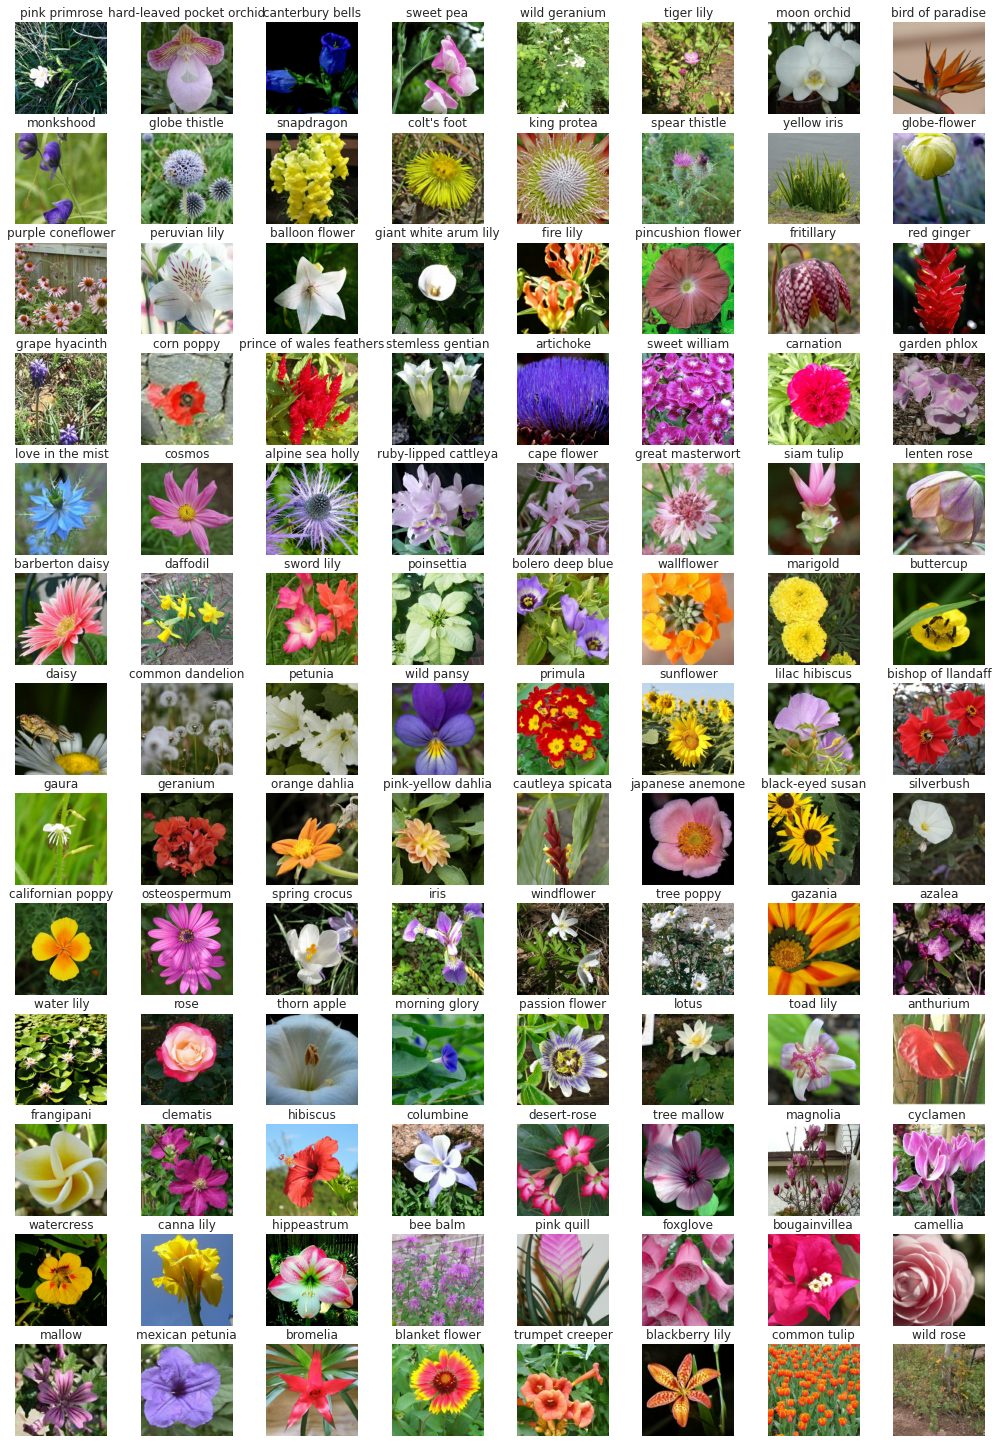

In [7]:
rows, cols = 13, 8
plt.figure(figsize=(2.2 * cols, rows * 2))

image_dict = dict([(key, None) for key in range(len(flower_categories))])

def is_not_full_yet():
    for key, value in image_dict.items():
        if value is None:
            return True
    return False

for i, (image, label) in enumerate(train_dataset.as_numpy_iterator()):
    if i >= num_training_samples:
        break

    if label in image_dict and image_dict[label] is None:
        plt.subplot(rows, cols, label + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_categories[label])
        image_dict[label] = True
    
    if not is_not_full_yet():
        break

# Data augmentation methods in GPU/TPU

The definition of our transformation object `transformer` is self explanatory. The `augmentation` method will be applied later by our training dataset (`tf.data.Dataset` object).

In [8]:
transformer = ktu.TFImageTransform(
    image_size,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_adjustments=True,
    rotation_range=15.,
    shear_range=5.,
    zoom_range=(0.1, 0.1),
    shift_range=(16., 16.)
)

def augmentation(image, label):
    return transformer.transform(image), label

Below are examples of our data augmentation algorithm. There are several data augmentation methods being used here. These methods can be divided into "Fast" and "Slow" categories:

1. Fast Augmentation Methods:
   - Random horizontal/vertical flip
   - Random brightness correction (up to certain gamma)
2. Slow Augmentation Methods:
   - Random Rotation (to the left or to the right, up to a certain degree)
   - Random shear (to the left or to the right, up to a certain degree)
   - Random zooming (in or out, horizontal or vertical, up to a certain value)
   - Random shifting (up to a certain value)

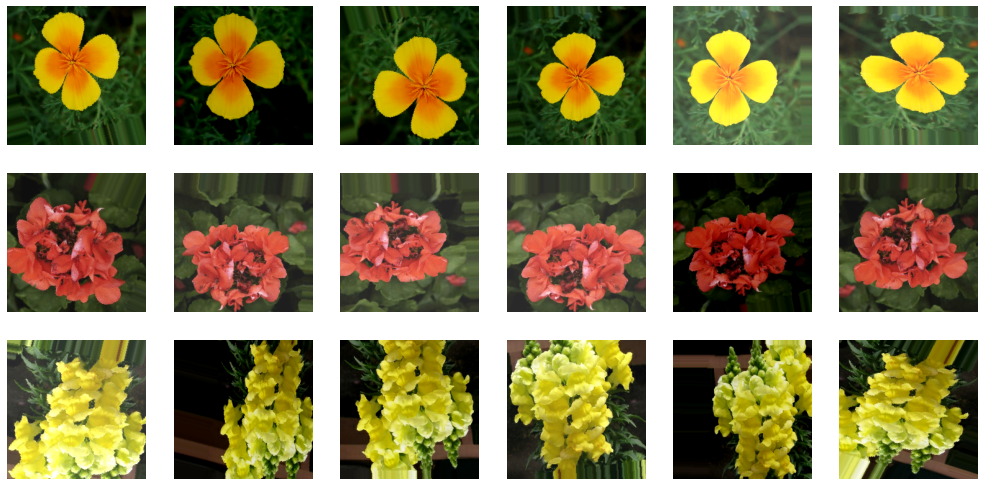

In [9]:
rows, cols = 3, 6
plt.figure(figsize=(2.9 * cols, rows * 2.9))

for row, element in zip(range(rows), train_dataset):
    one_element = tf.data.Dataset.from_tensors(element).repeat()
    for col, (image, _) in zip(range(cols), one_element.map(augmentation).as_numpy_iterator()):
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.axis('off')
        plt.imshow(image)

# Prepare, Build Model, and Train

Here we define how the data will be feeded to our model during training:

* For training dataset, we will apply random augmentations on each image, shuffle it, group into batches, and pre-fetch the data to our TPU (so that we don't have to wait for the data to be loaded each time). [`tf.data.experimental.AUTOTUNE`](https://www.tensorflow.org/guide/data_performance) will try to apply the most optimal fetching strategies, depending on our hardware configuration.
* For validation and testing datasets, we don't augment or shuffle (obviously), but employ the same prefetch method. Also, since our validation set is small, we will try to cache it.

Also, we define some [Keras Callbacks](https://keras.io/api/callbacks/) to improve our training:

* `early_stopping` - performs early stopping, i.e. halts the training if the validation loss has not improved in several epochs 
* `save_checkpoints` - just save intermediate models, so that we don't lose good models
* `lr_callback` - we will schedule our learning rate in such a way, that is suitable to fine-tuning from a pre-trained network

In [10]:
# Training Parameters
batch_size = 16 * strategy.num_replicas_in_sync
epochs = 30

# Prepare dataflow configuration
batched_train_dataset = train_dataset.map(augmentation)
batched_train_dataset = batched_train_dataset.repeat()
batched_train_dataset = batched_train_dataset.shuffle(buffer_size=2048)
batched_train_dataset = batched_train_dataset.batch(batch_size)
batched_train_dataset = batched_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Prepare validation configuration
batched_val_dataset = val_dataset.batch(batch_size)
batched_val_dataset = batched_val_dataset.cache()
batched_val_dataset = batched_val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Prepare testing configuration
batched_test_dataset = test_dataset.batch(batch_size)
batched_test_dataset = batched_test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Early Stopping callback - in case if we hit a plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Saving checkpoins every 4 epochs
save_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_freq='epoch', period=4)

# Learning Rate Scheduler for fine-tuning jobs (first increase lr, then decrease)
lr_callback = ktu.LRSchedulers.FineTuningLR(
    lr_start=1e-5, lr_max=5e-5 * strategy.num_replicas_in_sync, lr_min=1e-5,
    lr_rampup_epochs=5, lr_sustain_epochs=0, lr_exp_decay=0.8, verbose=1)

The `ktu.LRSchedulers.FineTuningLR` starts from a small learning rate (to preserve delicate pre-trained weights on Imagenet). Then, it gradually increases the learning rate and drops to minimum again at the end. The graph of the learning rate against batch number is shown below (you can see that lr changes only in the end of each epoch):

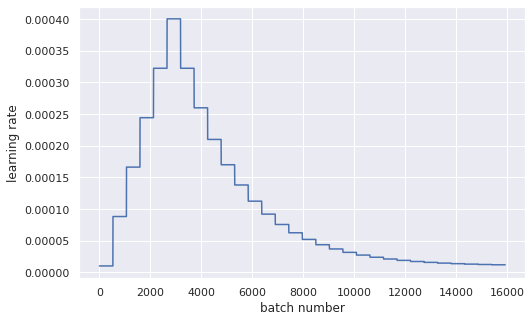

In [11]:
plt.figure(figsize=(8, 5))
lr_callback.visualize(steps_per_epoch=num_training_samples // batch_size, epochs=epochs)

Now we build our model, based on some pre-trained ImageNet feature extractor, and fine tune it for the new dataset. In this case, I chose [EfficientNetB7](https://github.com/qubvel/efficientnet), since it is shown by other competitors that this networks performs better on this competition than ResNets, DenseNets, VGGs, and other networks. Please notice that I am using `weights='noisy-student'` here - it obtained in [this paper earlier this year](https://arxiv.org/pdf/1911.04252.pdf) which gives better results on ImageNet than the original one.

Training is quite straightforward. For more information please refer to the [Keras Models API documentation](https://keras.io/api/models/).

In [12]:
def get_model():
    with strategy.scope():
        feature_extractor= efficientnet.EfficientNetB7(
            weights='noisy-student', include_top=False, input_shape=[*image_size, 3])
        feature_extractor.trainable = True
        
        model = tf.keras.Sequential([
            feature_extractor,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(flower_categories), activation='softmax', dtype='float32')
        ])
        
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

    return model


# Build model
model = get_model()
model.summary()

# Train model
history = model.fit(
    batched_train_dataset,
    steps_per_epoch=num_training_samples // batch_size,
    epochs=epochs,
    callbacks=[lr_callback, early_stopping, save_checkpoints],
    validation_data=batched_val_dataset,
    verbose=2)

258072576/258068648 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
531/531 - 170s - sparse_categorical_accuracy: 0.1003 - loss: 4.3715 - val_sparse_categorical_accuracy: 0.1142 - val_loss: 4.3360 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoc

# Generating submission

In [13]:
# Generate submission file
print('Generating Submission file...', end=' ')
test_images_dataset = batched_test_dataset.map(lambda image, idnum: image)
predictions = np.argmax(model.predict(test_images_dataset), axis=-1)
test_ids_dataset = batched_test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_dataset.batch(num_testing_samples))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
print('Done!')

Generating Submission file... Done!
